In [1]:
#Importing libraries
 
import os
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot
from pandas import DataFrame

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


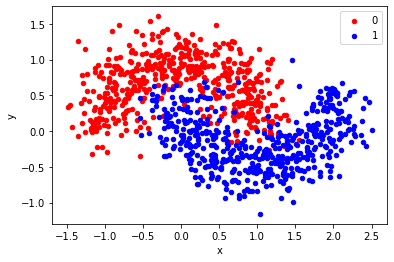

In [135]:
"""
    DATA PREPARATION
      > Loading the dataset and splitting it into train, cross validation and test sets
      > The inputs are to be in the format of X.shape = (number_of_examples, number_of features)
      > The outputs are to be in the format of y.shape = (number_of_output_units, number_of_examples)
"""
 
N_SAMPLES = 1000
TEST_SIZE = 0.1
X, y = make_moons(n_samples = N_SAMPLES, noise=0.25, random_state=100)
X_tr, X_te, y_tr_t, y_te_t = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)
y_tr_t = y_tr_t.reshape(y_tr_t.shape[0],1)
y_te_t = y_te_t.reshape(y_te_t.shape[0],1)
m_tr = y_tr_t.shape[0]
m_te = y_te_t.shape[0]
y_tr = y_tr_t.T
y_te = y_te_t.T
 
 
#Plotting the data
 
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

In [3]:
"""
    ACTIVATION FUNCTIONS
      > Defining the activation functions for the neural network. Note here that 
         the "tanh" activation function is implemented as "tang(x)"
"""
 
def sigmoid(x):
  return (1/(1+np.exp(-x)))
def relu(x):
    return np.maximum(0,x)
def tang(x):
  return np.tanh(x)

In [104]:
"""
    DEFINING UNITS AND ACTIVATION FUNCTIONS
      > Here the number of units in each layer and as a result the number of layers
         in our neural network is defined in a Python list "layer_dims"
      > Activation functions for each of the layers is also defined in the Python
         list "act_fn"
      > Note here that the length of act_fn is one less than that of the length of
         layer_dims
"""
 
layer_dims = [X_tr.shape[1],40,25,25,15,10,1]
act_fn = ["tang","tang","tang","tang","tang","sigmoid"]

In [5]:
"""
    INITIALISING THE PARAMETERS
      > The parameters of the neural network are 1.Weights and 2.Bias and these
         parameters are tweaked while training the network. 
      > Weights and bias for each of the layers(excluding the input layer) are
         initialised randomly and special weight initialisation techniques are
         used depending on the activation function of the layer.
      > Weights and bias are stored in the Python dictionary "parameters" and the
         weights of the ith layer are stored by keyword Wi and the bias in bi
      > Wi.shape = (number_of_units_in_(i-1)th_layer, number_of_units_in_(i)th_layer)
      > bi.shape = (number_of_units_in_(i)th_layer,1)
      > Arguments - layer_dims,act_fn
"""
 
def initialize_parameters(layer_dims,activation_fn):
  parameters = {}
  relu_init = 2
  tang_init = 1
  for i in range(1,len(layer_dims)):
    if activation_fn[i-1] is "relu":
      initi = relu_init
    if activation_fn[i-1] is "tang":
      initi = tang_init
    parameters["W"+str(i)] = np.random.randn(layer_dims[i],layer_dims[i-1])*np.sqrt(initi/layer_dims[i-1])
    parameters["b"+str(i)] = np.random.randn(layer_dims[i],1)*0.01
  return parameters

In [6]:
"""
    FORWARD PROPAGATION
      > The forward propagation makes a forward pass through the neural net. The
         outputs of all the layers are computed and then the activation
         for that particular layer is calculated.
      > The python dictionaries "outputs" are used to store the output of the dot
         product between the weights and the inputs and "activations" are used to
         store the activations of the outputs of that layer
      > The "outputs" contain keywords of the format Zi for the outputs of the ith
         layer and the "activations" contain keywords of the format Ai for the activations
         of the ith layer based on its activations as specified in "acts_fn"
      > The input data is also stored in A0 and is handy for back propagation
      > Arguments - Input_Data, parameters, activation_fn
"""
 
def forw_prop(X,parameters,activation_fn):
  outputs = {}
  activations = {}
  A_prev = X.T
  for o in range(1,len(layer_dims)):
    if activation_fn[o-1] is "relu":
      activ = relu
    if activation_fn[o-1] is "tang":
      activ = tang
    if activation_fn[o-1] is "sigmoid":
      activ = sigmoid
    outputs["Z" + str(o)] = np.dot(parameters["W" + str(o)],A_prev) + parameters["b"+str(o)]
    activations["A" + str(o)] = activ(outputs["Z" + str(o)])
    A_prev = activations["A" + str(o)]
  activations["A0"] = X.T
  return outputs,activations

In [7]:
def grad_L1_reg(parameters):
  comp = {}
  for f in range(1,len(layer_dims)):
    comp["W" + str(f)] = np.zeros(parameters["W" + str(f)].shape)
  for k in range(1,len(layer_dims)):
    for p in range(0,parameters["W" + str(k)].shape[0]):
      for n in range(0,parameters["W" + str(k)].shape[1]):
        if parameters["W" + str(k)][p,n] > 0:
          comp["W" + str(k)][p,n] = 1
        else:
          comp["W" + str(k)][p,n] = -1
  return comp

In [8]:
def L1_reg(comp,parameters,lamb,m_exam):
  temp_sum = 0
  grad_reg = {}
  for k in range(1,len(layer_dims)):
    temp_sum = temp_sum + ((lamb/m_exam)*(np.sum(np.sum(parameters["W" + str(k)]))))
    grad_reg["dW" + str(k)] = ((lamb/m_exam)*(comp["W" + str(k)]))
  return temp_sum,grad_reg

def L2_reg(parameters,lamb,m_exam):
  temp_sum = 0
  grad_reg = {}
  for k in range(1,len(layer_dims)):
    temp_sum = temp_sum + ((lamb/(2*m_exam))*(np.sum(np.sum(np.square(parameters["W" + str(k)])))))
    grad_reg["dW" + str(k)] = ((lamb/m_exam)*(parameters["W" + str(k)]))
  return temp_sum,grad_reg

In [41]:
"""
    COST FUNCTION
      > Cost function is calculated using the activations of the final layer of
         the network and the ground truth y
      > Arguments - activation, y, number_of_examples
"""
 
def cost_func(reg,lamb,parameters,A,y,m_exam):
  if reg is not None:
    if reg is "L1":
      comp = grad_L1_reg(parameters)
      temp_sum,grad_reg = L1_reg(comp,parameters,lamb,m_exam)
      cost = ((-1/m_exam)*(np.sum(np.sum((y*np.log(A)) + ((1-y)*np.log(1-A)))))) + temp_sum
    if reg is "L2":
      temp_sum,grad_reg = L2_reg(parameters,lamb,m_exam)
      cost = ((-1/m_exam)*(np.sum(np.sum((y*np.log(A)) + ((1-y)*np.log(1-A)))))) + temp_sum
  else:
    grad_reg = {}
    cost = ((-1/m_exam)*(np.sum(np.sum((y*np.log(A)) + ((1-y)*np.log(1-A))))))
    for r in range(1,len(layer_dims)):
      grad_reg["dW" + str(r)] = 0
  return cost,grad_reg

In [10]:
"""
    GRADIENTS OF ACTIVATION FUNCTIONS
      > Here the gradients of the activation functions are defined.
      > This calculates the derivative of the activation of the ith layer to the
         outputs of the ith layer
      > Arguments - outputs Z
"""
 
def sigmoid_backward(z):
  grad_back = np.exp(-z)/np.square(1+np.exp(-z))
  return grad_back
def relu_backward(x):
  x[x<=0] = 0
  x[x>0] = 1
  return x
def tang_backward(x):
  return (1 - np.square(np.tanh(x)))

In [11]:
"""
    PREDICTIONS
      > The predictions for the outputs of the network are calculated given a
         threshold value for predicting the class of the input data according to
         the parameters learned by the network.
      > Arguments - A(Activations),threshold_for_classification
"""
 
def predict(A,threshold):
  predictions = np.zeros((A.shape))
  for i in range(0,A.shape[0]):
    for j in range(0,A.shape[1]):
      if A[i,j]>threshold:
        predictions[i,j]=1
      else:
        predictions[i,j]=0
  return predictions

In [12]:
def create_mini_batches(X,Y,m_ex,mb_size):
  mini_batch = {}
  num = m_ex//mb_size
  f = 0
  for i in range(0,num):
    mini_batch["MB_X" + str(i)] = X[f:(f+mb_size),:]
    mini_batch["MB_Y" + str(i)] = Y[:,f:(f+mb_size)]
    f = f + mb_size
  mini_batch["MB_X" + str(num)] = X[f:m_ex,:]
  mini_batch["MB_Y" + str(num)] = Y[:,f:m_ex]
  return mini_batch,num

In [13]:
def grad_des(grad_reg,m_examp,alpha,grads,Y,activation_fn,outputs,activations,parameters):
  if activation_fn[len(layer_dims)-2] is "relu":
    backward = relu_backward
  if activation_fn[len(layer_dims)-2] is "tang":
    backward = tang_backward
  if activation_fn[len(layer_dims)-2] is "sigmoid":
    backward = sigmoid_backward
  grads["dA" + str(len(layer_dims)-1)] = (1/m_examp)*(((1-Y)/(1-activations["A" + str(len(layer_dims)-1)])) - (Y/activations["A" + str(len(layer_dims)-1)]))
  grads["dZ" + str(len(layer_dims)-1)] = grads["dA" + str(len(layer_dims)-1)]*backward(outputs["Z" + str(len(layer_dims)-1)])
  grads["dW" + str(len(layer_dims)-1)] = (np.dot(grads["dZ" + str(len(layer_dims)-1)],activations["A" + str(len(layer_dims)-2)].T)) + grad_reg["dW" + str(len(layer_dims)-1)]
  grads["db" + str(len(layer_dims)-1)] = np.sum(grads["dZ" + str(len(layer_dims)-1)],axis=1,keepdims=True)
  for j in reversed(range(1,len(layer_dims)-1)):
    if activation_fn[j-1] is "relu":
      backward = relu_backward
    if activation_fn[j-1] is "tang":
      backward = tang_backward
    if activation_fn[j-1] is "sigmoid":
      backward = sigmoid_backward
    grads["dA" + str(j)] = np.dot(parameters["W" + str(j+1)].T,grads["dZ" + str(j+1)])
    grads["dZ" + str(j)] = grads["dA" + str(j)]*backward(outputs["Z" + str(j)])
    grads["dW" + str(j)] = (np.dot(grads["dZ" + str(j)],activations["A" + str(j-1)].T)) + grad_reg["dW" + str(j)]
    grads["db" + str(j)] = np.sum(grads["dZ" + str(j)],axis=1,keepdims=True)
  for k in range(1,len(layer_dims)):
    parameters["W" + str(k)] -= (alpha*(grads["dW" + str(k)]))
    parameters["b" + str(k)] -= (alpha*(grads["db" + str(k)]))
  return parameters

 
def gd_mom(grad_reg,m_examp,V_dict,grads,alpha,beta1,Y,activation_fn,outputs,activations,parameters):
  if activation_fn[len(layer_dims)-2] is "relu":
    backward = relu_backward
  if activation_fn[len(layer_dims)-2] is "tang":
    backward = tang_backward
  if activation_fn[len(layer_dims)-2] is "sigmoid":
    backward = sigmoid_backward
  grads["dA" + str(len(layer_dims)-1)] = (1/m_examp)*(((1-Y)/(1-activations["A" + str(len(layer_dims)-1)])) - (Y/activations["A" + str(len(layer_dims)-1)]))
  grads["dZ" + str(len(layer_dims)-1)] = grads["dA" + str(len(layer_dims)-1)]*backward(outputs["Z" + str(len(layer_dims)-1)])
  grads["dW" + str(len(layer_dims)-1)] = (np.dot(grads["dZ" + str(len(layer_dims)-1)],activations["A" + str(len(layer_dims)-2)].T)) + grad_reg["dW" + str(len(layer_dims)-1)]
  grads["db" + str(len(layer_dims)-1)] = np.sum(grads["dZ" + str(len(layer_dims)-1)],axis=1,keepdims=True)
  for j in reversed(range(1,len(layer_dims)-1)):
    if activation_fn[j-1] is "relu":
      backward = relu_backward
    if activation_fn[j-1] is "tang":
      backward = tang_backward
    if activation_fn[j-1] is "sigmoid":
      backward = sigmoid_backward
    grads["dA" + str(j)] = np.dot(parameters["W" + str(j+1)].T,grads["dZ" + str(j+1)])
    grads["dZ" + str(j)] = grads["dA" + str(j)]*backward(outputs["Z" + str(j)])
    grads["dW" + str(j)] = (np.dot(grads["dZ" + str(j)],activations["A" + str(j-1)].T)) + grad_reg["dW" + str(j)]
    grads["db" + str(j)] = np.sum(grads["dZ" + str(j)],axis=1,keepdims=True)
  for h in range(1,len(layer_dims)):
    V_dict["Vdw" + str(h)] = (beta1*V_dict["Vdw" + str(h)]) + ((1-beta1)*grads["dW" + str(h)])
    V_dict["Vdb" + str(h)] = (beta1*V_dict["Vdb" + str(h)]) + ((1-beta1)*grads["db" + str(h)])
  for g in range(1,len(layer_dims)):
    parameters["W" + str(g)] -= (alpha*(V_dict["Vdw" + str(g)]))
    parameters["b" + str(g)] -= (alpha*(V_dict["Vdb" + str(g)]))
  return parameters
 
 
def rms_prop(grad_reg,m_examp,S_dict,grads,epsilon,alpha,beta2,Y,activation_fn,outputs,activations,parameters):
  if activation_fn[len(layer_dims)-2] is "relu":
    backward = relu_backward
  if activation_fn[len(layer_dims)-2] is "tang":
    backward = tang_backward
  if activation_fn[len(layer_dims)-2] is "sigmoid":
    backward = sigmoid_backward
  grads["dA" + str(len(layer_dims)-1)] = (1/m_examp)*(((1-Y)/(1-activations["A" + str(len(layer_dims)-1)])) - (Y/activations["A" + str(len(layer_dims)-1)]))
  grads["dZ" + str(len(layer_dims)-1)] = grads["dA" + str(len(layer_dims)-1)]*backward(outputs["Z" + str(len(layer_dims)-1)])
  grads["dW" + str(len(layer_dims)-1)] = (np.dot(grads["dZ" + str(len(layer_dims)-1)],activations["A" + str(len(layer_dims)-2)].T)) + grad_reg["dW" + str(len(layer_dims)-1)]
  grads["db" + str(len(layer_dims)-1)] = np.sum(grads["dZ" + str(len(layer_dims)-1)],axis=1,keepdims=True)
  for j in reversed(range(1,len(layer_dims)-1)):
    if activation_fn[j-1] is "relu":
      backward = relu_backward
    if activation_fn[j-1] is "tang":
      backward = tang_backward
    if activation_fn[j-1] is "sigmoid":
      backward = sigmoid_backward
    grads["dA" + str(j)] = np.dot(parameters["W" + str(j+1)].T,grads["dZ" + str(j+1)])
    grads["dZ" + str(j)] = grads["dA" + str(j)]*backward(outputs["Z" + str(j)])
    grads["dW" + str(j)] = (np.dot(grads["dZ" + str(j)],activations["A" + str(j-1)].T)) +  grad_reg["dW" + str(j)]
    grads["db" + str(j)] = np.sum(grads["dZ" + str(j)],axis=1,keepdims=True)
  for h in range(1,len(layer_dims)):
    S_dict["Sdw" + str(h)] = (beta2*S_dict["Sdw" + str(h)]) + ((1-beta2)*np.square(grads["dW" + str(h)]))
    S_dict["Sdb" + str(h)] = (beta2*S_dict["Sdb" + str(h)]) + ((1-beta2)*np.square(grads["db" + str(h)]))
  for g in range(1,len(layer_dims)):
    parameters["W" + str(g)] -= ((alpha*grads["dW" + str(g)])/(np.sqrt(S_dict["Sdw" + str(g)]) + epsilon))
    parameters["b" + str(g)] -= ((alpha*grads["db" + str(g)])/(np.sqrt(S_dict["Sdb" + str(g)]) + epsilon))
  return parameters
 
def adam(grad_reg,t,m_examp,epsilon,grads,V_dict,S_dict,alpha,beta1,beta2,Y,activation_fn,outputs,activations,parameters):
  S_dict_corr = {}
  V_dict_corr = {}
  if activation_fn[len(layer_dims)-2] is "relu":
    backward = relu_backward
  if activation_fn[len(layer_dims)-2] is "tang":
    backward = tang_backward
  if activation_fn[len(layer_dims)-2] is "sigmoid":
    backward = sigmoid_backward
  grads["dA" + str(len(layer_dims)-1)] = (1/m_examp)*(((1-Y)/(1-activations["A" + str(len(layer_dims)-1)])) - (Y/activations["A" + str(len(layer_dims)-1)]))
  grads["dZ" + str(len(layer_dims)-1)] = grads["dA" + str(len(layer_dims)-1)]*backward(outputs["Z" + str(len(layer_dims)-1)])
  grads["dW" + str(len(layer_dims)-1)] = (np.dot(grads["dZ" + str(len(layer_dims)-1)],activations["A" + str(len(layer_dims)-2)].T)) + grad_reg["dW" + str(len(layer_dims)-1)]
  grads["db" + str(len(layer_dims)-1)] = np.sum(grads["dZ" + str(len(layer_dims)-1)],axis=1,keepdims=True)
  for j in reversed(range(1,len(layer_dims)-1)):
    if activation_fn[j-1] is "relu":
      backward = relu_backward
    if activation_fn[j-1] is "tang":
      backward = tang_backward
    if activation_fn[j-1] is "sigmoid":
      backward = sigmoid_backward
    grads["dA" + str(j)] = np.dot(parameters["W" + str(j+1)].T,grads["dZ" + str(j+1)])
    grads["dZ" + str(j)] = grads["dA" + str(j)]*backward(outputs["Z" + str(j)])
    grads["dW" + str(j)] = (np.dot(grads["dZ" + str(j)],activations["A" + str(j-1)].T)) + grad_reg["dW" + str(j)]
    grads["db" + str(j)] = np.sum(grads["dZ" + str(j)],axis=1,keepdims=True)
  for h in range(1,len(layer_dims)):
    V_dict["Vdw" + str(h)] = (beta1*V_dict["Vdw" + str(h)]) + ((1-beta1)*grads["dW" + str(h)])
    V_dict["Vdb" + str(h)] = (beta1*V_dict["Vdb" + str(h)]) + ((1-beta1)*grads["db" + str(h)])
  for c in range(1,len(layer_dims)):
    S_dict["Sdw" + str(c)] = (beta2*S_dict["Sdw" + str(c)]) + ((1-beta2)*np.square(grads["dW" + str(c)]))
    S_dict["Sdb" + str(c)] = (beta2*S_dict["Sdb" + str(c)]) + ((1-beta2)*np.square(grads["db" + str(c)]))
  for n in range(1,len(layer_dims)):
    S_dict_corr["Sdw" + str(n)] = S_dict["Sdw" + str(n)]/(1 - np.power(beta2,t))
    S_dict_corr["Sdb" + str(n)] = S_dict["Sdb" + str(n)]/(1 - np.power(beta2,t))
    V_dict_corr["Vdw" + str(n)] = V_dict["Vdw" + str(n)]/(1 - np.power(beta1,t))
    V_dict_corr["Vdb" + str(n)] = V_dict["Vdb" + str(n)]/(1 - np.power(beta1,t))
  for g in range(1,len(layer_dims)):
    parameters["W" + str(g)] -= ((alpha*V_dict["Vdw" + str(g)])/(np.sqrt(S_dict_corr["Sdw" + str(g)]) + epsilon))
    parameters["b" + str(g)] -= ((alpha*V_dict["Vdb" + str(g)])/(np.sqrt(S_dict_corr["Sdb" + str(g)]) + epsilon))
  return parameters

In [101]:
"""
    FIT
      > This function is used to train the network on training data and the weights
         are updated by backpropagation through Optimization functions (Gradient descent,RMSprop,Adam)
      > Returns "costs" a Python list consisting of all the costs through the iterations
         and the updated "parameters" dictionary
      > Returns the "master_cache" which contains the values of outputs, activations,
         parameters throughout the training period of the format "master_cache["Z" + str(j) + str(_) + str(i)]
         returns the outputs of the jth layer in the ith iteration of training"
      > Arguments - X(train),Y(train),number_of_training_examples,number_of_iterations,
         learning_rate,parameters,activation_fn,print_cost(True/False),callback
"""
 
def fit(reg,lamb,X,Y,m_ex,num_iterations,alpha,mb,optim,params,activation_fn,print_cost,callback=None):
  costs = []
  costs_cache = []
  if mb is True:
    mini_batches,num = create_mini_batches(X,Y,m_ex,mb_size)
  p = 0
  m = 0
  V_dict = {}
  S_dict = {}
  for k in range(1,len(layer_dims)):
    V_dict["Vdw" + str(k)] = np.zeros(params["W" + str(k)].shape)
    V_dict["Vdb" + str(k)] = np.zeros(params["b" + str(k)].shape)
    S_dict["Sdw" + str(k)] = np.zeros(params["W" + str(k)].shape)
    S_dict["Sdb" + str(k)] = np.zeros(params["b" + str(k)].shape)
  
  for i in range(1,num_iterations+1):
    
    if ((((optim is "BGD") or (optim is "Momentum")) or ((optim is "RMSprop") or (optim is "Adam"))) and (mb is False)):
      grads = {}
      outputs,activations = forw_prop(X,params,activation_fn)
      cost,grad_regs = cost_func(reg,lamb,params,activations["A" + str(len(layer_dims)-1)],Y,m_ex)
      costs.append(cost)
      costs_cache.append(cost)
      predictions = predict(activations["A" + str(len(layer_dims)-1)],0.5)
      if optim == "BGD":
        params = grad_des(grad_regs,m_ex,alpha,grads,Y,activation_fn,outputs,activations,params)
      if optim == "Momentum":
        params = gd_mom(grad_regs,m_ex,V_dict,grads,alpha,0.9,Y,activation_fn,outputs,activations,params)
      if optim == "RMSprop":
        params = rms_prop(grad_regs,m_ex,S_dict,grads,1e-8,alpha,0.999,Y,activation_fn,outputs,activations,params)
      if optim == "Adam":
        params = adam(grad_regs,i,m_ex,1e-8,grads,V_dict,S_dict,alpha,0.9,0.999,Y,activation_fn,outputs,activations,params)

    if ((((optim is "mBGD") or (optim is "Momentum")) or ((optim is "RMSprop") or (optim is "Adam"))) and (mb is True)):
      predictions_py = []
      for u in range(0,num+1):
        grads = {}
        outputs,activations = forw_prop(mini_batches["MB_X" + str(u)],params,activation_fn)
        cost,grad_regs = cost_func(reg,lamb,params,activations["A" + str(len(layer_dims)-1)],mini_batches["MB_Y" + str(u)],mini_batches["MB_X" + str(u)].shape[0])
        costs_cache.append(cost)
        predict_MB = predict(activations["A" + str(len(layer_dims)-1)],0.5)
        for w in range(0,predict_MB.shape[1]):
          predictions_py.append(predict_MB[:,w])
        if optim == "mBGD":
          params = grad_des(grad_regs,mini_batches["MB_Y" + str(u)].shape[1],alpha,grads,mini_batches["MB_Y" + str(u)],activation_fn,outputs,activations,params)
        if optim == "Momentum":
          params = gd_mom(grad_regs,mini_batches["MB_Y" + str(u)].shape[1],V_dict,grads,alpha,0.9,mini_batches["MB_Y" + str(u)],activation_fn,outputs,activations,params)
        if optim == "RMSprop":
          params = rms_prop(grad_regs,mini_batches["MB_Y" + str(u)].shape[1],S_dict,grads,1e-8,alpha,0.999,mini_batches["MB_Y" + str(u)],activation_fn,outputs,activations,params)
        if optim == "Adam":
          params = adam(grad_regs,i,mini_batches["MB_Y" + str(u)].shape[1],1e-8,grads,V_dict,S_dict,alpha,0.9,0.999,mini_batches["MB_Y" + str(u)],activation_fn,outputs,activations,params)
      m = m+1
      temp = costs_cache[(num*m)+(m-1)]
      costs.append(temp)
      predictions = np.array(predictions_py).T
      

    if optim is "SGD":
      predictions_py = []
      for q in range(0,m_ex):
        grads = {}
        x = X[q,:]
        x = x.reshape(1,2)
        y = Y[:,q]
        y = y.reshape(1,1)
        outputs,activations = forw_prop(x,params,activation_fn)
        cost,grad_regs = cost_func(reg,lamb,params,activations["A" + str(len(layer_dims)-1)],Y[:,q],1)
        costs_cache.append(cost)
        params = grad_des(grad_regs,1,alpha,grads,y,activation_fn,outputs,activations,params)
        predict_SGD = predict(activations["A" + str(len(layer_dims)-1)],0.5)
        for w in range(0,predict_SGD.shape[1]):
          predictions_py.append(predict_SGD[:,w])
      m = m+1
      temp = costs_cache[(m_ex*m)-1]
      costs.append(temp)
      predictions = np.array(predictions_py).T
    
    if ((print_cost is True) and (i%1==0)):
        print("Cost after iteration " + str(i) + " is " + str(np.squeeze(costs[p])) + " -------- " + "Training accuracy = " + str(np.squeeze(float(np.mean(predictions==Y,axis=1))*100)))
    p = p+1
    if(i % 1 == 0):
      if(callback is not None):
                callback(i, params)
  return costs, costs_cache, params#, master_cache

In [15]:
"""
    PRECISION RECALL AND F1 SCORE
      > Function is defined to calculate the precision, recall and F1 scores of the test and
         cross validation data
      > Returns the precision, recall and F1 score
      > Arguments - Predictions_of_the_final_activation, y(ground_truth)
"""
 
def prec_rec(A,y):
  tp = 0
  fp = 0
  fn = 0
  for i in range(0,y.shape[1]):
    if ((A[0,i]==1)and(y[0,i]==1)):
      tp = tp+1
    if ((A[0,i]==1)and(y[0,i]==0)):
      fp = fp+1
    if (A[0,i]==0)and(y[0,i]==1):
      fn = fn+1
  prec = tp/(tp+fp)
  rec = tp/(tp+fn)
  f1 = (2*prec*rec)/(prec+rec)
  return prec,rec,f1

In [16]:
"""
    PERFORMANCE ON TEST AND CROSS VALIDATION DATA
      > This function evaluates the performance of the learning algorithm on test
         and cross validation data
      > Returns the accuracy, precision, recall and F1 score of test and cross validation
         datasets
      > Arguments - X,y,trained_parameters,print_values(True/False)
"""
 
def cross_val(X,y,params_tr,print_values):
  out_cv,act_cv = forw_prop(X,params_tr,act_fn)
  predictions_cv = predict(act_cv["A" + str(len(layer_dims)-1)],0.5)
  accu_cv = float(np.mean(predictions_cv==y,axis=1))*100
  prec_cv,rec_cv,f1_cv = prec_rec(predictions_cv,y)
  if print_values is True:
    print("CROSS VAL RESULTS: ")
    print("Cross val accuracy = " + str(accu_cv))
    print("Precision: " + str(prec_cv))
    print("Recall: " + str(rec_cv))
    print("F1 score: " + str(f1_cv))
    print('\n')
    print('\n')
  return accu_cv,prec_cv,rec_cv,f1_cv
def test(X,y,params_tr,print_values):
  out_te,act_te = forw_prop(X,params_tr,act_fn)
  predictions_te = predict(act_te["A" + str(len(layer_dims)-1)],0.5)
  accu_te = float(np.mean(predictions_te==y,axis=1))*100
  prec_te,rec_te,f1_te = prec_rec(predictions_te,y)
  if print_values is True:
    print("TEST RESULTS: ")
    print("Testing accuracy = " + str(accu_te))
    print("Precision: " + str(prec_te))
    print("Recall: " + str(rec_te))
    print("F1 score: " + str(f1_te))
    print('\n')
    print('\n')
  return accu_te,prec_te,rec_te,f1_te

In [140]:
#Training the network

mb_size = 64
parameters_dat = initialize_parameters(layer_dims,act_fn)
costs,costs_cache,parameters = fit("L2",0.01,X_tr,y_tr,m_tr,100,0.003,True,"Adam",parameters_dat,act_fn,print_cost=True)

Cost after iteration 1 is 0.5730230822580578 -------- Training accuracy = 70.22222222222221
Cost after iteration 2 is 0.3773122908243518 -------- Training accuracy = 82.55555555555556
Cost after iteration 3 is 0.319876458755339 -------- Training accuracy = 84.66666666666667
Cost after iteration 4 is 0.2964774245961227 -------- Training accuracy = 86.77777777777777
Cost after iteration 5 is 0.2754620808998115 -------- Training accuracy = 87.33333333333333
Cost after iteration 6 is 0.2627532017024388 -------- Training accuracy = 87.1111111111111
Cost after iteration 7 is 0.2545907070009187 -------- Training accuracy = 87.66666666666667
Cost after iteration 8 is 0.24763896848258227 -------- Training accuracy = 87.77777777777777
Cost after iteration 9 is 0.24262377605999325 -------- Training accuracy = 88.1111111111111
Cost after iteration 10 is 0.2386056542274706 -------- Training accuracy = 88.22222222222223
Cost after iteration 11 is 0.2354109431553041 -------- Training accuracy = 88.55

In [141]:
#cross_val(X_cv,y_cv,parameters,print_values=True)
test(X_te,y_te,parameters,print_values=True)

TEST RESULTS: 
Testing accuracy = 95.0
Precision: 0.9183673469387755
Recall: 0.9782608695652174
F1 score: 0.9473684210526316






(95.0, 0.9183673469387755, 0.9782608695652174, 0.9473684210526316)

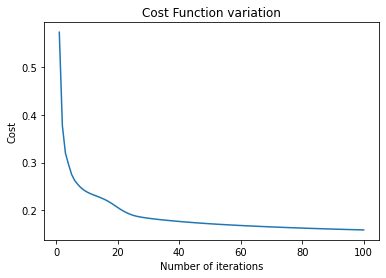

In [142]:
#Plotting Cost vs Number of Iterations

import matplotlib.pyplot as plt
itera = np.arange(1,len(costs)+1,1)
plt.xlabel('Number of iterations')
plt.ylabel('Cost')
plt.title('Cost Function variation')
plt.plot(itera,costs)

In [20]:
#Decision Boundary Visualisation helper functions
#Remember to set the path to which the graphs should be stored in "OUTPUT_DIR"

sns.set_style("whitegrid")
GRID_X_START = -1.5
GRID_X_END = 2.5
GRID_Y_START = -1.0
GRID_Y_END = 2
OUTPUT_DIR = "/content/drive/My Drive/Colab Notebooks/nn_visuals/ADAM_moon_noreg_500_0.005_32_T"
grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j]
grid_2d = grid.reshape(2,-1)
XX, YY = grid
def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    if(file_name):
        plt.savefig(file_name)
        plt.close()
import os
def callback_numpy_plot(index, init_params):
    plot_title = "Iteration {:05}".format(index)
    file_name = "numpy_model_{:05}.png".format(index//10)
    file_path = os.path.join(OUTPUT_DIR, file_name)
    out,act = forw_prop(np.transpose(grid_2d),init_params,act_fn)
    prediction_probs = act["A" + str(len(layer_dims)-1)]
    prediction_probs = prediction_probs.reshape(prediction_probs.shape[1], 1)
    make_plot(X_te, y_te, plot_title, file_name=file_path, XX=XX, YY=YY, preds=prediction_probs, dark=True)

In [21]:
#Decision Boundary Visualisation

mb_size = 32
layer_dims_vis = layer_dims
layer_dims_vis[0] = 2
parameters_dat = initialize_parameters(layer_dims_vis,act_fn)
_,_,params_values = fit(None,0,X_tr,y_tr,m_tr,1000,0.005,True,"Adam",parameters_dat,act_fn,print_cost=False,callback=callback_numpy_plot)

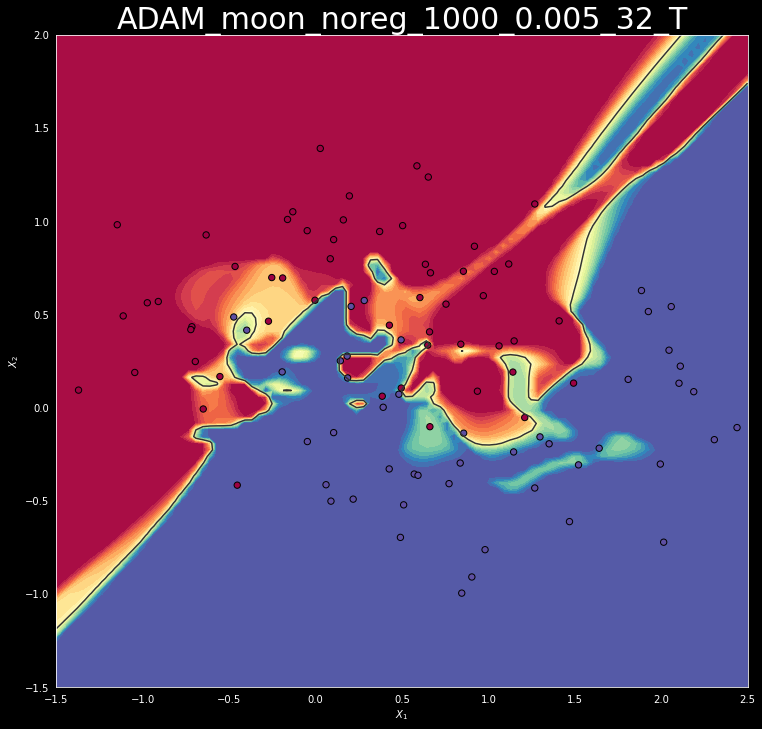

In [22]:
#Get the final Decision Boundary at the end of training evaluated on the test set 

out,act = forw_prop(np.transpose(grid_2d),params_values,act_fn)
prediction_probs_np = act["A" + str(len(layer_dims)-1)]
prediction_probs_np = prediction_probs_np.reshape(prediction_probs_np.shape[1], 1)
make_plot(X_te, y_te, "ADAM_moon_noreg_1000_0.005_32_T", file_name=None, XX=XX, YY=YY, preds=prediction_probs_np, dark=True)